In [1]:
%load_ext autoreload
%autoreload 2

# Import

In [2]:
import time
import os
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.tensorboard import SummaryWriter

import sys
sys.path.append("..")

import numpy
from tqdm import tqdm

# dataset manager
from dcase2020.datasetManager import DESEDManager
from dcase2020.datasets import DESEDDataset

# utility function & metrics & augmentation
from metric_utils.metrics import FScore, BinaryAccuracy
from dcase2020_task4.util.utils import get_datetime, reset_seed
from dcase2020_task4.util.checkpoint import CheckPoint


In [3]:
# ==== set the log ====
import logging
import logging.config
from dcase2020.util.log import DEFAULT_LOGGING
logging.config.dictConfig(DEFAULT_LOGGING)
log = logging.getLogger(__name__)

In [4]:
# ==== reset the seed for reproductability ====
reset_seed(1234)

# Prepare the data

In [5]:
# ==== load the dataset ====
desed_metadata_root = "../dataset/DESED/dataset/metadata"
desed_audio_root = "../dataset/DESED/dataset/audio"

manager = DESEDManager(
    desed_metadata_root, desed_audio_root,
    sampling_rate = 22050,
    from_disk=False,
    nb_vector_bin=431, # there is no temporal reduction in this model
    verbose = 1
)

DEBUG --- datasetManager.__init__ >>> ../dataset/DESED/dataset/audio/dcase2020_dataset_22050.hdf5
INFO --- datasetManager._load_metadata >>> Reading metadata: ../dataset/DESED/dataset/metadata/train/weak.tsv
INFO --- datasetManager._load_metadata >>> Reading metadata: ../dataset/DESED/dataset/metadata/train/unlabel_in_domain.tsv
INFO --- datasetManager._load_metadata >>> Reading metadata: ../dataset/DESED/dataset/metadata/train/synthetic20.tsv


## Add weak ans synthetic20 subset

In [6]:
manager.add_subset("validation")

100%|██████████| 4251/4251 [00:08<00:00, 483.08it/s]

INFO --- datasetManager._add_val_subset >>> Loading dataset: validation
DEBUG --- datasetManager._hdf_to_dict >>> hdf_file: <HDF5 file "dcase2020_dataset_22050.hdf5" (mode r)>


DEBUG --- datasetManager._hdf_to_dict >>> path: DESED/dataset/audio/validation


# Prepare dataset and model

## Prep dataset

- We want both the weak and strong ground truth --> the *weak* and *strong* parameters to True
- only the validation subset is needed

In [7]:
val_dataset = DESEDDataset(manager, train=False, val=True, weak=True, strong=True, augments=[], cached=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

## Prep model

### dcase2019_system

In [8]:
from dcase2020_task4.dcase2019.models import dcase2019_model

In [9]:
best_model = dcase2019_model()
best_model.cuda()
best_model.eval() # <-- for consistency in scoring (deactivate dropout and batchNorm)

checkpoint = torch.load("../models/best_dcase2019.torch")
best_model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

## Perform prediction on validation dataset

In [11]:
weak_y_true, strong_y_true = None, None
weak_y_pred, strong_y_pred = None, None
y_filenames = list(val_dataset.X.keys())

with torch.set_grad_enabled(False):
    for i, (X, y) in enumerate(val_loader):
        weak_y, strong_y = y
        weak_y, strong_y = weak_y.cuda(), strong_y.cuda()
        X = X.cuda()
        
        weak_logits, strong_logits = best_model(X)
        
        weak_pred = torch.sigmoid(weak_logits)
        strong_pred = torch.sigmoid(strong_logits)
        
        # accumulate prediction and ground truth
        if i == 0:
            weak_y_true = weak_y.cpu()
            strong_y_true = strong_y.cpu()

            weak_y_pred =  weak_pred.cpu()
            strong_y_pred =  strong_pred.cpu()
        else:
            weak_y_true = torch.cat((weak_y_true, weak_y.cpu()), dim=0)
            strong_y_true = torch.cat((strong_y_true, strong_y.cpu()), dim=0)

            weak_y_pred =  torch.cat((weak_y_pred, weak_pred.cpu()), dim=0)
            strong_y_pred =  torch.cat((strong_y_pred, strong_pred.cpu()), dim=0)
        
        print(" %d %%" % int(100 * (i + 1) / len(val_loader)), end="\r")

In [12]:
weak_y_true.shape, weak_y_pred.shape, strong_y_true.shape, strong_y_pred.shape, len(y_filenames)

(torch.Size([1058, 10]),
 torch.Size([1058, 10]),
 torch.Size([1058, 10, 431]),
 torch.Size([1058, 10, 431]),
 1058)

# Audio tagging threshold Optimization

In [13]:
classwise_f1 = FScore(dim=0)
def simulated_anealing(y_pred, y_true, macro_iteration = 50, micro_iteration = 400):
    weak_y_pred_ = y_pred.clone().detach()

    classwise_f1(weak_y_pred_, weak_y_true)
    start_f1 = classwise_f1.value

    min_delta = 10e-7
    delta_ratio = 0.2
#     macro_iteration = 30
#     micro_iteration = 400

    history = {
        "best_f1": [[] for _ in range(10)],
        "f1": [],
        "delta_ratio": []
    }

    best_thresholds = torch.ones(10) * 0.5
    best_f1 = start_f1.clone().detach()

    total_iteration = macro_iteration * micro_iteration
    
    for M in range(macro_iteration):
        thresholds = torch.ones(10) * 0.5
        delta_ratio = 0.3
        delta_decay = ( (min_delta + delta_ratio) / micro_iteration )

        for m in range(micro_iteration):
            bin_y_pred = y_pred.clone().detach()

            # calc new threhsold
            r = torch.normal(mean=thresholds, std=0.4)
            delta = r * delta_ratio
            new_thresholds = thresholds + delta
            delta_ratio -= delta_decay
            history["delta_ratio"].append(delta_ratio)

            # apply threshold
            weak_y_pred_[bin_y_pred > new_thresholds] = 1
            weak_y_pred_[bin_y_pred <= new_thresholds] = 0

            # calc new f1
            classwise_f1(weak_y_pred_, weak_y_true)
            new_f1 = classwise_f1.value
            history["f1"].append(new_f1)

            # check
            for i in range(10):
                if new_f1[i] > best_f1[i]:
#                     print(new_f1[i], " > ", best_f1[i])
                    best_f1[i] = new_f1[i]
                    best_thresholds[i] = new_thresholds[i]
                    thresholds[i] = best_thresholds[i]
                    history["best_f1"][i].append(best_f1[i])
#                     print(best_thresholds)

            step = M * micro_iteration + m
            print("%2.2f / 100.0 (%%)" % ((step / total_iteration) * 100), end="\r")
            
    return start_f1, best_f1, best_thresholds, history

In [14]:
initial_f1, best_f1, best_at_thresholds, history = simulated_anealing(weak_y_pred, weak_y_true, 20, 400)

In [15]:
torch.mean(initial_f1), torch.mean(best_f1)

(tensor(0.6882), tensor(0.7030))

In [16]:
best_at_thresholds

tensor([0.3663, 0.1117, 0.9624, 0.9105, 0.9772, 0.5160, 0.5000, 0.4193, 0.5802,
        0.2022])

# pruning of strong prediction

## Apply best tagging threshold

In [17]:
best_weak_y_pred = weak_y_pred.clone().detach()

best_weak_y_pred[best_weak_y_pred > best_at_thresholds] = 1
best_weak_y_pred[best_weak_y_pred <= best_at_thresholds] = 0

In [18]:
best_weak_y_pred.shape, strong_y_pred.shape

(torch.Size([1058, 10]), torch.Size([1058, 10, 431]))

In [19]:
# Prune the result of fill the missing curve with 0 segments
def prune_prediction(strong_y_pred, weak_y_pred):
    """ Prune the strong prediciton by zeroing all classes that are not predicted. """
    pruned_strong_y_pred = strong_y_pred.clone().detach()
    
    for index in range(len(pruned_strong_y_pred)):
        cls_result = weak_y_pred[index]
        
        # Create a full mask using repeat
        length = strong_y_pred.size()[-1]
        cls_mask = cls_result.unsqueeze(1).repeat(1, length)
        pruned_strong_y_pred[index] *= cls_mask
                
    return pruned_strong_y_pred

In [20]:
pruned_strong_y_pred = prune_prediction(strong_y_pred, best_weak_y_pred)

### Sanity check and visualization

In [21]:
best_weak_y_pred[1], pruned_strong_y_pred[1]

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.2967, 0.1147, 0.1788,  ..., 0.0047, 0.0092, 0.0386]]))

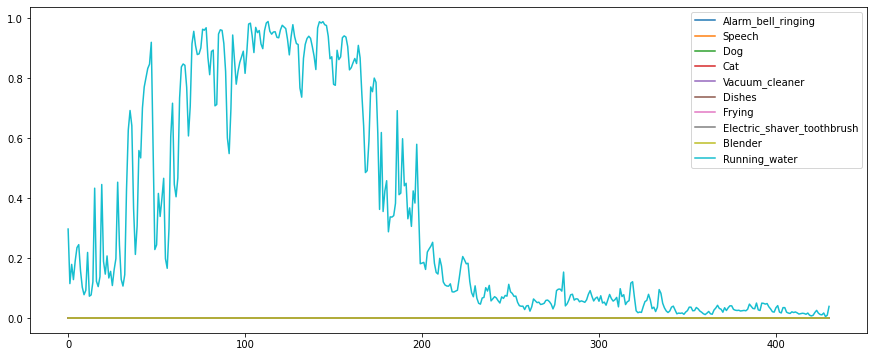

In [23]:
import matplotlib.pyplot as plt

class_list = list(DESEDManager.cls_dict.keys())
plt.figure(0, figsize=(15, 6))

for i, class_name in enumerate(class_list):
    plt.plot(pruned_strong_y_pred[1][i], label=class_name)

plt.legend()
plt.show()

# localization Optimization

In [24]:
# pip install -i https://test.pypi.org/simple/ aeseg

In [25]:
from aeseg.Encoder import Encoder
from aeseg.optimizers import GenOptimizer, DichotomicOptimizer
from aeseg.core import eb_evaluator, sb_evaluator

In [26]:
def load_csv(path):
    with open(path, "r") as f:
        data = f.read().splitlines()[1:]
    return data

In [27]:
## Optimizer take data in the following shape (file, seq, class)
strong_y_true = strong_y_true.permute(0, 2, 1)
pruned_strong_y_pred = pruned_strong_y_pred.permute(0, 2, 1)
strong_y_true.shape, pruned_strong_y_pred.shape

(torch.Size([1058, 431, 10]), torch.Size([1058, 431, 10]))

In [ ]:
def class_wise_optimization(optimizer, class_to_monitor, strong_y_true, strong_pred, filenames, method="threshold"):
    class_wise_results = {}
    
    for cl in class_to_monitor:
        optimizer.fit(
            strong_y_true, strong_pred, filenames,
            monitor=["class_wise", cl, "f_measure", "f_measure"],
            method=method,
            verbose=1)
        
        parameters, score = optimizer.best
        print(cl, parameters, score)
        class_wise_results[cl] = (parameters, score)
        
    return class_wise_results


def get_class_dependant_parameters(class_wise_results, class_list):
    class_dependant_parameters = {}
    for cl in class_list:
        for param in class_wise_results[cl][0]:
            if param not in class_dependant_parameters.keys():
                class_dependant_parameters[param] = []
            class_dependant_parameters[param].append(class_wise_results[cl][0][param])
            
    # TODO find better way
    # for "smooth" common parameters, remove list
    class_dependant_parameters["smooth"] = class_dependant_parameters["smooth"][0]
    return class_dependant_parameters

In [ ]:
class_list = list(DESEDManager.cls_dict.keys())

# Create the encoder that will be used
encoder = Encoder(
    classes=class_list,
    temporal_precision = 50,  # ms
    clip_length = 10,          # s
    minimal_segment_step = 150 # ms
)

val_csv_y_true= load_csv(os.path.join(desed_metadata_root, "validation", "validation.tsv"))

## Absolute threshold

In [ ]:
optimizer = DichotomicOptimizer(
    {
        "threshold": (0.01, 0.90),
        "smooth": "smoothMovingAvg",
        "window_len": (5, 27)
    },
    
    encoder = encoder,
    step = 6,
    nb_recurse = 8,
    nb_process = 5
)

class_wise_results = class_wise_optimization(
    optimizer,
    class_list,
    method="threshold",
    strong_y_true=val_csv_y_true,
    strong_pred=pruned_strong_y_pred.numpy(),
    filenames=y_filenames
)

## Hysteresis thresholding

In [241]:
# Perform the optimization ON TEST
# Create the optimizer
optimizer = DichotomicOptimizer(
    {
        "high": (0.01, 0.99),
        "low": (0.01, 0.99),
#         "smooth": "smoothMovingAvg",
        "window_len": (3, 27)
    },
    
    encoder = encoder,
    step = 6,
    nb_recurse = 8,
    nb_process = 5
)

class_wise_results = class_wise_optimization(
    optimizer,
    class_list,
    method="hysteresis",
    strong_y_true=strong_y_true,
    strong_pred=pruned_strong_y_pred.numpy(),
    filenames=y_filenames
)














  0%|          | 0/1728 [00:00<?, ?it/s]

IndexError: list index out of range

In [87]:
best_parameters = get_class_dependant_parameters(class_wise_results, class_list)

In [88]:
# check test
best_parameters = get_class_dependant_parameters(class_wise_results, class_list)

segments = encoder.encode(
    val_strong_pred,
    method="hysteresis",
    **best_parameters
)
to_evaluate = encoder.parse(segments, val_filenames)
evaluator = eb_evaluator(val_csv_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 10161.15 sec
  Evaluated files                   : 1168 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 36.63 %
    Precision                       : 40.38 %
    Recall                          : 33.52 %
  Error rate
    Error rate (ER)                 : 1.13 
    Substitution rate               : 0.03 
    Deletion rate                   : 0.64 
    Insertion rate                  : 0.47 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 37.88 %
    Precision                       : 39.53 %
    Recall                          : 36.98 %
  Error rate
    Error rate (ER)                 : 1.21 
    Deletion rate                   : 0.63 
    Insertion rat

# ♫♪.ılılıll|̲̅̅●̲̅̅|̲̅̅=̲̅̅|̲̅̅●̲̅̅|llılılı.♫♪